*Unit 4, Sprint 1, Module 3*

---

# Document Classification (Prepare)

Today's guided module project will be different. You already know how to do classification. You ready know how to extract features from documents. So? That means you're ready to combine and practice those skills in a [kaggle competition](https://www.kaggle.com/c/whiskey-201911/). We we will open with a five minute sprint explaining the competition, and then give you 25 minutes to work. After those twenty five minutes are up, I will give a 5-minute demo an NLP technique that will help you with document classification (*and **maybe** the competition*).

Today's all about having fun and practicing your skills. The competition will begin

## Learning Objectives
* <a href="#p1">Part 1</a>: Text Feature Extraction & Classification Pipelines
* <a href="#p2">Part 2</a>: Latent Semantic Indexing
* <a href="#p3">Part 3</a>: Word Embeddings with Spacy

## Challenge -- this afternoon's lab module assignment

1. Join Lambda School's [Whiskey Classification Kaggle Competition](https://www.kaggle.com/c/whiskey-201911/)
2. Download the data
3. Train a model & try: 
    - Creating a Text Extraction & Classification Pipeline
    - Tune the pipeline with a `GridSearchCV` or `RandomizedSearchCV`
    - Add some Latent Semantic Indexing (lsi) into your pipeline. *Note:* You can grid search a nested pipeline, but you have to use double underscores to specify parameters from each level in the nested pipeline. For example, `lsi__svd__n_components` specifies the parameter `n_components` inside the `svd` pipeline, which is nested inside the `lsi` pipeline
    - Try to extract word embeddings with Spacy and use those embeddings as your features for a classification model.
4. Make a submission to Kaggle 

# 1. Text Feature Extraction & Classification Pipelines (Learn)
<a id="p1"></a>

## Overview

Sklearn pipelines allow you to stitch together multiple components of a machine learning process. The idea is that you can pass your raw data and get predictions out of the pipeline. This ability to pass raw input and receive a prediction from a singular class makes pipelines well suited for production, because you can pickle a pipeline without worry about other data preprocessing steps. 

*Note:* Each time we call the pipeline during grid search, each component is fit again. The vectorizer (tf-idf) transforms our entire vocabulary during each cross-validation fold. That transformation adds significant run time to our grid search. There *might* be interactions between the vectorizer and our classifier, so we estimate their performance together in the code below. However, if your goal is to reduce run time, train your vectorizer separately (ie out of the grid-searched pipeline). 

##1.1 Prepare Colab notebook

###1.1.1 Get Spacy

In [1]:
# Locally (or on colab) let's use en_core_web_lg
!python -m spacy download en_core_web_md # Can do lg, takes awhile

     |████████████████████████████████| 96.4 MB 67.0 MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-py3-none-any.whl size=98051302 sha256=bdbac93aa3b2f466f1415ae4b821115a5ca0e262b5be7213ee936ba93efe35e8
  Stored in directory: /tmp/pip-ephem-wheel-cache-r5wp_9s2/wheels/69/c5/b8/4f1c029d89238734311b3269762ab2ee325a42da2ce8edb997
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


###1.1.2 Restart runtime!

###1.1.3 Imports

In [1]:
# Import Statements
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import spacy

from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import MinMaxScaler, StandardScaler
%matplotlib inline

### 1.1.4 Load spacy

In [2]:
# load in pre-trained w2v model 
nlp = spacy.load("en_core_web_md")

##1.2 Example NLP document classification pipeline 
Working with the [`20newsgroups` data set](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html#sklearn.datasets.fetch_20newsgroups) available from `sklearn`, <br>we'll build a classifier that can classify news articles into 2 different categories.

### 1.2.1 Get the data set

In [3]:
# Dataset
from sklearn.datasets import fetch_20newsgroups

# 2 categories
categories = ['alt.atheism',
              'talk.religion.misc']

data = fetch_20newsgroups(subset='all', 
                          remove=('headers', 'footers', 'quotes'),
                          random_state=42, shuffle=True,
                          categories=categories)

#### 1.2.2 Examine and understand the data set!

In [4]:
type(data)

sklearn.utils.Bunch

In [5]:
print(dir(data))
n_targets = len(data['target_names'])
print(f'\nThere are {n_targets} target names:')
print(data['target_names'])
target_values = np.unique(data['target'])
print(f'\nThe target values are {target_values}')
n_files = len(data['filenames'])
print(f'\nThere are {n_files} data files; each contains one newsgroup post labeled 0 or 1')
first_filename = data.filenames[0]
print(f'Here is the name of the first data file\n:{first_filename} ')

['DESCR', 'data', 'filenames', 'target', 'target_names']

There are 2 target names:
['alt.atheism', 'talk.religion.misc']

The target values are [0 1]

There are 1427 data files; each contains one newsgroup post labeled 0 or 1
Here is the name of the first data file
:/root/scikit_learn_data/20news_home/20news-bydate-train/talk.religion.misc/84101 


In [ ]:
data['DESCR']

'.. _20newsgroups_dataset:\n\nThe 20 newsgroups text dataset\n------------------------------\n\nThe 20 newsgroups dataset comprises around 18000 newsgroups posts on\n20 topics split in two subsets: one for training (or development)\nand the other one for testing (or for performance evaluation). The split\nbetween the train and test set is based upon a messages posted before\nand after a specific date.\n\nThis module contains two loaders. The first one,\n:func:`sklearn.datasets.fetch_20newsgroups`,\nreturns a list of the raw texts that can be fed to text feature\nextractors such as :class:`sklearn.feature_extraction.text.CountVectorizer`\nwith custom parameters so as to extract feature vectors.\nThe second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,\nreturns ready-to-use features, i.e., it is not necessary to use a feature\nextractor.\n\n**Data Set Characteristics:**\n\n    =================   ==========\n    Classes                     20\n    Samples total            

### How  would you classify this post? i.e., Religion or Atheism?

In [6]:
print(type(data.data))
print(len(data.data))
print(data.data[0])

<class 'list'>
1427

I'm sorry, but He does not!  Ever read the FIRST commandment?



###1.2.3 Function to clean the data

In [7]:
def clean_data(text):
    """
    Accepts a single text document and performs several regex substitutions in order to clean the document. 
    
    Parameters
    ----------
    text: string or object 
    
    Returns
    -------
    text: string or object
    """
    
    # order of operations - apply the expression from top to bottom
    email_regex = r"From: \S*@\S*\s?"
    non_alpha = '[^a-zA-Z]'
    multi_white_spaces = "[ ]{2,}"
    
    text = re.sub(email_regex, "", text)
    text = re.sub(non_alpha, ' ', text)
    text = re.sub(multi_white_spaces, " ", text)
    
    # apply case normalization 
    return text.lower().lstrip().rstrip()

In [9]:
print(type(data.data))
print(len(data.data))

<class 'list'>
1427


### 1.2.4 Create and run a pipeline

In [23]:
# prep data, instantiate a model, create pipeline object, and run a gridsearch 

###BEGIN SOLUTION
# save our model input data to X
X = data.data #data['data']

# save our targets/labels to y
y = data.target

# clean our docs 
X_clean = [clean_data(post) for post in X]

# Create Pipeline Components

# create vectorizer
tfidf = TfidfVectorizer(stop_words="english", tokenizer=None) # data transformer 

# create classifier
rfc = RandomForestClassifier(random_state=42) # estimator 

# Instantiate a pipeline object -- which is a list of tuples
#   Each tuple specifies (name of the pipeline component, the pipeline component)
pipe = Pipeline([("vect", tfidf), # data transformer
                 ("clf", rfc)])   # classifier 



In [24]:
%%time
# create a hyper-parameter dictionary for BOTH our vectorizer and our ML model 
# here we will determine which tfidf parameter values lead to the best performing model
parameters = {
    'vect__max_df': ( 0.75, 0.9, 1.0),
    'vect__min_df': ( 2, 10, 15),
    'vect__max_features': (500, 750, 1000),
    'clf__n_estimators':(10, 100, 1000),
    'clf__max_depth':(15, 20, 25)
}

# Instantiate a GridSearchCV object
gs = GridSearchCV(pipe, param_grid=parameters, n_jobs=-1, cv=3, verbose=1)
# Note: For n_jobs below -1, (n_cpus + 1 + n_jobs) are used. For example with n_jobs=-2, all CPUs but one are used.

gs.fit(X_clean, y)
###END SOLUTION

Fitting 3 folds for each of 243 candidates, totalling 729 fits
CPU times: user 21.3 s, sys: 995 ms, total: 22.3 s
Wall time: 7min 3s


Establishing a baseline accuracy with a naive model

In [12]:
frac_ones = y.sum()/len(y)
frac_ones

0.4400840925017519

Since the majority class is zeros, naive model is to predict all zeros!

In [14]:
y_naive_pred = np.zeros((1,len(y)))

array([[0., 0., 0., ..., 0., 0., 0.]])

Naive model error, if we predict all zeros

In [15]:
frac_error = np.abs(y_naive_pred - y).sum()/len(y)
print(frac_error)

0.4400840925017519


Naive model accuracy

In [16]:
baseline_accuracy = 1-frac_error
print(baseline_accuracy)

0.559915907498248


Pipeline results after hyperparameter tuning!

In [25]:
gs.best_score_

0.7098732124428718

In [26]:
gs.best_params_

{'clf__max_depth': 25,
 'clf__n_estimators': 1000,
 'vect__max_df': 0.75,
 'vect__max_features': 750,
 'vect__min_df': 2}

In [19]:
best_model = gs.best_estimator_
best_model

Pipeline(steps=[('vect',
                 TfidfVectorizer(max_df=0.75, max_features=500, min_df=10,
                                 stop_words='english')),
                ('clf', RandomForestClassifier(max_depth=20, random_state=42))])

Getting your predictions using the pipeline

In [20]:
# because the vectorizer was included in the pipeline object
# we can simply pass in raw text data into gs and it will provide a classification
y_pred = gs.predict(X_clean)

In [21]:
# this is what you would submit to Kaggle
y_pred


array([0, 1, 0, ..., 1, 1, 0])

In [22]:
print(len(y_pred))

1427


#2. Topic Modeling via Latent Semantic Analysis (LSA)
a.k.a. Latent Semantic Indexing (LSI)
<a id="p2"></a>

## Overview
Below is an excellent visual representation of *Latent Semantic Indexing*, also known as LSI, and as *Latent Semantic Analyis*, or LSA.<br>
Latent Semantic Indexing is a technique for Topic  Modeling, i.e. grouping a corpus of documents into similar clusters that can then be examined for topics. In the graphic below read "context" as "topics"<br>

Grouping documents into clusters with different topics is also a form of dimensionality reduction, because the document can be represented by a vector of topics instead of a vector of tokens. <br>

If your document-term matrix has $m$ documents and $n$ terms, <br>and the number of topics you want to find is $k$, then:
- The Term-Document Matrix is $n\times m$ (the transpose of the Document-Term Matrix)
- The Word Assignment to Topics Matrix is $n \times k$
- The Topic Importance Matrix is $k \times k$
- The Topic Distribution Across Documents Matrix is $k \times m$

[](https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1538411402/image3_maagmh.png)

![](https://media.geeksforgeeks.org/wp-content/uploads/20210406165951/Screenshot20210406165933.png)<br>
Image Credit: [Geeks for Geeks](https://media.geeksforgeeks.org/)

The image above shows a decomposition of the term-document matrix into a product of three matrices.<br>

- word = term (token or lemma)
- context means "topic" or document grouping


In the term-document matrix, the columns are vector representations of documents

In the words-context matrix, the columns represent relative weighting of words for each topic

In the context-document matrix, the columns represent relative weighting of topics for each document 


**Take Aways:** LSA has two main benefits

1. Dimensionality Reduction (because you can choose the number of topics $k \ll n$)
2. Topic Modeling is a form of feature engineering, because it identifies latent (hidden) topics that are present in our doc-term matrix. <br>
This is something that counting vectorizers can't do (i.e. `CountVectorizer`, `TfidfVEctorizer`)

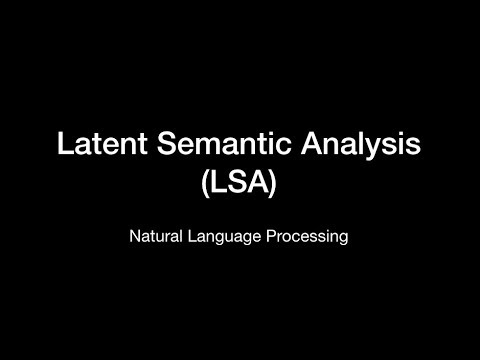

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('OvzJiur55vo', width=1024, height=576)

## 2.1 An example of Latent Semantic Analysis

Before we apply Latent Semantic Analysis in a pipeline, let's work through a simple example together in order to better understand how LSA works and develop an intuition along the way. 

First, if you haven't already, watch the short video provided above. We will be implementing the example from the video in our notebook. 

In [27]:
# Import

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer

svd = TruncatedSVD(n_components=2, # number of topics to generate (also the size of the new feature space)
                   algorithm='randomized',
                   n_iter=10)

# let's use the same data that was used in the video for consistancy 

        # topic 1 data 
data = ["pizza", 
        "pizza hamburger cookie",
        "hamburger", 
        # topic 2 data
        "ramen", 
        "sushi", 
        "ramen sushi"]

In [29]:
# CREATE Term-Frequency matrix 

###BEGIN SOLUTION
# use CountVectorizer to create a Term-Frequency matrix (a.k.a. Doc-Term Matrix )
tf_vectorizer = CountVectorizer()
tfm = tf_vectorizer.fit_transform(data)
tfm = pd.DataFrame(data=tfm.toarray(), columns=tf_vectorizer.get_feature_names())

# switch integer indices with terms
tfm.index = data
tfm
###END SOLUTION

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,cookie,hamburger,pizza,ramen,sushi
pizza,0,0,1,0,0
pizza hamburger cookie,1,1,1,0,0
hamburger,0,1,0,0,0
ramen,0,0,0,1,0
sushi,0,0,0,0,1
ramen sushi,0,0,0,1,1


In [30]:
# Use Singular Value Decomposition (SVD)to transform our Term-Frequency matrix into a Topic matrix with reduced dimensionality
# LSA is just an application of SVD


###BEGIN SOLUTION
# Use SVD to transform our Term-Frequency matrix into a Topic matrix with reduced dimensionality
X_reduced = svd.fit_transform(tfm)

# this is the output of SVD
# same number of rows 
# number of features has been reduced to 2 
X_reduced.round(2)
###END SOLUTION

array([[ 0.63, -0.  ],
       [ 1.72, -0.  ],
       [ 0.63,  0.  ],
       [ 0.  ,  0.71],
       [ 0.  ,  0.71],
       [ 0.  ,  1.41]])

In [31]:
# let's move X_reduced into a dataframe and rename the indices and columns for interpretability  

###BEGIN SOLUION
# let's move X_reduced into a dataframe and rename the indices and columns for interpretability  
topic_cols = ["topic_1", "topic_2"]
dtm_reduced = pd.DataFrame(data=X_reduced.round(2), columns=topic_cols)
dtm_reduced.index = data
dtm_reduced
###END SOLUTION

,topic_1,topic_2
pizza,0.63,-0.00
pizza hamburger cookie,1.72,-0.00
hamburger,0.63,0.00
ramen,0.00,0.71
sushi,0.00,0.71
ramen sushi,0.00,1.41


## 2.2 Build a Latent Semantic Analysis (LSA) pipeline
Now that we've gone through an example of applying LSA on a small dataset, <br>let's implement it in a classification pipeline to run on the `20newsgroups`data. <br>
In this case we are only using LSA for dimensionality reduction.


In [32]:
# build a pipeline, incorporate SVD, and run a gridsearch 

###BEGIN SOLUTION -- ask svd to truncate to the best 100 principal components, i.e. find 100 "topics"
svd = TruncatedSVD(n_components=None, 
                   algorithm='randomized',
                   n_iter=10)

# instantiate a pipeline object
lsi = Pipeline([("vect", tfidf), # creating our term-doc matrix
                ("svd", svd)]) # apply svd to our term-doc matrix 

# instantiate a pipeline object
pipe = Pipeline([("lsi", lsi), # data transform
                 ("clf", rfc)]) # estimator 

# a nice default starter set for hyper-parameter values
# include more parameters and values to try to increase model performance 
params = { 
    'lsi__svd__n_components': [10, 100, 200],
    'lsi__vect__max_df':[.95,  1.0],
    'clf__n_estimators':[100, 300, 1000], 
    'clf__max_depth':(15, 20)
}


gs = GridSearchCV(pipe,
                  param_grid=params, 
                  cv=3, 
                  n_jobs=-1, 
                  verbose=1 )



In [33]:
%%time
gs.fit(X_clean, y)
###END SOLUTION

Fitting 3 folds for each of 36 candidates, totalling 108 fits
CPU times: user 15.4 s, sys: 3.11 s, total: 18.6 s
Wall time: 3min 1s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('lsi',
                                        Pipeline(steps=[('vect',
                                                         TfidfVectorizer(stop_words='english')),
                                                        ('svd',
                                                         TruncatedSVD(n_components=100,
                                                                      n_iter=10))])),
                                       ('clf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__max_depth': (15, 20),
                         'clf__n_estimators': [100, 300, 1000],
                         'lsi__svd__n_components': [10, 100, 200],
                         'lsi__vect__max_df': [0.95, 1.0]},
             verbose=1)

What results can we get from the `gs` object?

In [34]:
dir(gs)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_feature_names',
 '_check_n_features',
 '_check_refit_for_multimetric',
 '_estimator_type',
 '_format_results',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_pairwise',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_required_parameters',
 '_run_search',
 '_select_best_index',
 '_validate_data',
 'best_estimator_',
 'best_index_',
 'best_params_',
 'best_score_',
 'classes_',
 'cv',
 'cv_results_',
 'decision_function',
 'error_score',
 'estimator',
 'fit',
 'get_params',
 'inverse_transform',
 'multimetric_',
 'n_features_

In [35]:
gs.best_params_

{'clf__max_depth': 15,
 'clf__n_estimators': 1000,
 'lsi__svd__n_components': 100,
 'lsi__vect__max_df': 1.0}

Using LSA, we got a slightly better score than before

In [36]:
gs.best_score_

0.7196933510246204

## Challenge

Be able to apply Latent Semantic Indexing (LSI) to various datasets. 

#3. Word Embeddings with Spacy (Learn)
In this section we'll complete our preparation for Lambda School's [Whiskey Classification Kaggle Competition](https://www.kaggle.com/c/whiskey-201911/)
<a id="p3"></a>

## Follow Along
Join the [Whiskey Classification Kaggle Competition](https://www.kaggle.com/c/whiskey-201911/)

## 3.1 Get the data
- Download the [data](https://www.kaggle.com/c/whiskey-201911/data) to your local machine
- Upload the data from your local machine to your Colab notebook by first clicking the **folder icon** in the left sidebar, then clicking the **folder icon with the white up arrow** that appears directly under "Files" in the left sidebar, then selecting the `whiskey-201911.zip` file. That file's icon should now appear in the left sidebar.
- To get the path to `whiskey-201911.zip` in the Colab environment, hover over its icon, click the three vertical dots that appear on the right, then select "Copy path".
- Finally, unzip `whiskey-201911.zip` and read the `.csv` files.


In [37]:
!unzip '/content/whiskey-201911.zip'
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

Archive:  /content/whiskey-201911.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [38]:
train

,id,description,category
0,1,A marriage of 13 and 18 year old bourbons. A m...,2
1,2,There have been some legendary Bowmores from t...,1
2,3,This bottling celebrates master distiller Park...,2
3,4,What impresses me most is how this whisky evol...,1
4,9,"A caramel-laden fruit bouquet, followed by une...",2
...,...,...,...
2581,4146,"Earthy, fleshy notes with brooding grape notes...",1
2582,4153,With its overt floral perfume notes and the sc...,4
2583,4154,"An unaged whiskey from Carroll County, Iowa, w...",3
2584,4155,"Fiery peat kiln smoke, tar, and ripe barley on...",1


In [ ]:
train['category'].value_counts()

1    1637
2     449
3     300
4     200
Name: category, dtype: int64

##3.2 Build, train, and evaluate a document classifier on the whiskey reviews!
As practice for this afternoon's module assignment, we'll run a Random Forest classification model on the Whiskey data set and get a preliminary result<br><br>
Unlike in our work in Sections 1 and 2 above, this time we'll train our classifer on document vectors derived from `spaCy`<br><br>
Question: <br>
Does `spaCy` use `CountVectorizer()`, `TfidfVectorizer()` or `word2vec` to vectorize text?<br><br>

*Note: It would also be interesting to use `spaCy` to vectorize the `20newsgroups` data, <br>
then run the same pipelines as in Sections $1$ and $2$ above and compare the resulting accuracies.*


In [39]:
%%time
# build a model that is trained on word vectors 

###BEGIN SOLUTION
def get_word_vectors(docs):
    """
    This serves as both our tokenizer and vectorizer. 
    Returns a list of document vectors, i.e. our doc-term matrix
    """
    return [nlp(doc).vector for doc in docs]
    

# raw text data for train and test sets
X_train_text = train["description"]
X_test_text = test["description"]

# transform raw data into doc-term matrices for train and test sets 
X_train = get_word_vectors(X_train_text)
X_test = get_word_vectors(X_test_text)

# save ratings to y vector
y_train = train["category"]



CPU times: user 1min 2s, sys: 175 ms, total: 1min 2s
Wall time: 1min 2s


In [ ]:
print(len(X_train))
print(len(X_test))

2586
288


Questions: 
What information do the entries of of `X_train` contain? <br>
Why does each element in `X_train` have the following shape?<br>

In [40]:
X_train[0].shape

(300,)

### Fit the Whiskey reviews to a Random Forest Classifier
We'll fit a Random Forest model, and we will use `oob_score` (oob means "out-of-bag")<br>
for a quick estimate of the generalization performance. <br>
The term *bag* comes from *bootstrap aggregation*, the process of building trees for the random forest model. <br>
Each tree in the forest is a "bootstrap" sample, meaning that it's constructed by *randomly* drawing N data points <br>
-- *with replacement* -- from the training set. That is of course why the model is called Random Forest!<br>
Here $N$ is the number of data points in the training set.<br>

For best results in this afternoon's assignment, however, you will do hyperparameter tuning using GridSearchCV 

In [42]:
rfc = RandomForestClassifier(oob_score=True)

rfc.fit(X_train, y_train)


RandomForestClassifier(oob_score=True)

The training accuracy is perfect, due to massive overfitting!

In [43]:
# train set accuracy -- massively overfitted!
rfc.score(X_train, y_train)

1.0

The out-of-bag accuracy score provides a rough estimate of the generalization error we could expect from the model.

In [44]:
rfc.oob_score_

0.731245166279969

## Challenge  -- this afternoon's lab module assignment

1. Join Lambda School's [Whiskey Classification Kaggle Competition](https://www.kaggle.com/c/whiskey-201911/)
2. Download the data
3. Train and hyperparameter tune a model: 
    - Create a Text Extraction & Classification Pipeline
    - Tune the pipeline with a `GridSearchCV` or `RandomizedSearchCV`
    - Add Latent Semantic Indexing (LSI) into your pipeline. *Note:* You can grid search a nested pipeline, but you have to use double underscores ie `lsi__svd__n_components`
    - Try to extract word embeddings with Spacy and use those embeddings as your features for a classification model.
4. Make a submission to Kaggle 

Note: You can put together your project from code snippets from the current Colab notebook. <br>
Alternatively, you can adapt and refactor this [Colab notebook](https://drive.google.com/file/d/1ZY-P33tXD5y-VucOjg2TXO5OAQBWuTLf/view?usp=sharing) to work with the Kaggle data for your project.

For the classifier model, you can try any or several of these models
* `RandomForestClassifier()` or `GradientBoostingClassifier()` from the `sklearn` library
* `XGBClassifier()` from the `xgboost` library
* `CatboostClassifier() from the `catboost` library
* `LGBMClassifier()` from the `lightgbm` library

# Post Lecture Assignment (Stretch)
<a id="p4"></a>

Your primary assignment this afternoon is to achieve a minimum of 80% accuracy on the Kaggle competition. <br>
Once you've accomplished that, do (1), and either (2) or (3): 

1. Research "Sentiment Analysis". Provide answers in markdown to the following questions: 
    - What is "Sentiment Analysis"? 
    - Is Document Classification different than "Sentiment Analysis"? Provide evidence for your response
    - How do people create labeled sentiment data? Are those labels really sentiment?
    - What are common applications of sentiment analysis?

2. Singular Value Decomposition (SVD) is one of the most important and powerful methods in Applied Mathematics and in all of Machine Learning.  Principal Components Analysis (PCA) -- which we used in Module 2 -- is closely releated to SVD. Research SVD using the resources below. Then write a few paragraphs explaining -- in your own words -- your understanding of SVD and why it has become so important in Machine Learning. As you write, pretend that you will be presenting this summary orally as an answer to a question during a job interview.<br>

* [Daniela Witten](https://www.danielawitten.com/), a Professor of Mathematical Statistics at the University of Washington, recently penned a highly amusing and informative [tweetstorm](https://twitter.com/WomenInStat/status/1285611042446413824) about SVD, well worth reading!<br>
* [Stanford University Lecture on SVD](https://www.youtube.com/watch?v=P5mlg91as1c) <br>
* [StatQuest Principal Components Analysis](https://www.youtube.com/watch?v=FgakZw6K1QQ)<br>
* [Luis Serrano Principal Components Analysis](https://www.youtube.com/watch?v=g-Hb26agBFg)<br>

3. Research which other models can be used for text classification -- see [Multi-Class Text Classification Model Comparison and Selection](https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568)
  - Try a few other classical machine learning models, and compare with the gradient boosting results 
  - Neural Networks are becoming more popular for document classification. Why is that the case? 
  - If you have the time and interest, check out this [text classification documentation](https://developers.google.com/machine-learning/guides/text-classification/step-2-5) from Google
   